## 1. IMPORTS & SETUP

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os
import sys

print("✓ Libraries imported")
print(f"PyTorch version: {torch.__version__}")
print(f"Available device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

✓ Librerie importate
PyTorch version: 2.7.1+cu118
Device disponibile: cuda


## 2. DATA LOADING

In [ ]:
# Read the Parquet file OVEN
Oven = pd.read_parquet("datasets_by_subject/Warmtepomp-Sturing.parquet")
Oven['_time'] = pd.to_datetime(Oven['_time'])
Oven = Oven.sort_values('_time').reset_index(drop=True)
print(f"Oven loaded: {Oven.shape[0]} rows, {Oven.shape[1]} columns")
Oven.head()

Oven caricato: 35037 righe, 12 colonne


,_time,_measurement,_field,_value,building,device_ID,msr_ID,msr_category,msr_device,msr_extra,msr_spec,msr_subject
0,2024-10-20 02:15:00,Electricity,kW,-0.007910,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000029,Power_active,Smappee,L2,Consumption_Production,Warmtepomp - Sturing
1,2024-10-20 02:30:00,Electricity,kW,-0.007956,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000029,Power_active,Smappee,L2,Consumption_Production,Warmtepomp - Sturing
2,2024-10-20 02:45:00,Electricity,kW,-0.007950,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000029,Power_active,Smappee,L2,Consumption_Production,Warmtepomp - Sturing
3,2024-10-20 03:00:00,Electricity,kW,-0.007968,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000029,Power_active,Smappee,L2,Consumption_Production,Warmtepomp - Sturing
4,2024-10-20 03:15:00,Electricity,kW,-0.007880,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000029,Power_active,Smappee,L2,Consumption_Production,Warmtepomp - Sturing


In [ ]:
# Load BUILDING (extract from main dataset if necessary)
building_path = "datasets_by_subject/Building.parquet"

if not os.path.exists(building_path):
    print("Extracting Building from main dataset...")
    df_main = pd.read_parquet("influxdb_query_20251020_074134.parquet")
    Building = df_main[df_main['msr_subject'] == 'Building'].copy()
    Building = Building.sort_values('_time').reset_index(drop=True)
    Building.to_parquet(building_path, compression='snappy', engine='fastparquet')
    print(f"✓ Building saved to {building_path}")
else:
    Building = pd.read_parquet(building_path)
    Building['_time'] = pd.to_datetime(Building['_time'])

print(f"Building loaded: {Building.shape[0]} rows, {Building.shape[1]} columns")
Building.head()

Building caricato: 140148 righe, 12 colonne


,_time,_measurement,_field,_value,building,device_ID,msr_ID,msr_category,msr_device,msr_extra,msr_spec,msr_subject
index,,,,,,,,,,,,
420440,2024-10-20 02:15:00,Electricity,kW,0.198563,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000038,Power_active,Smappee,Total,Consumption,Building
420441,2024-10-20 02:30:00,Electricity,kW,0.228958,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000038,Power_active,Smappee,Total,Consumption,Building
420442,2024-10-20 02:45:00,Electricity,kW,0.216411,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000038,Power_active,Smappee,Total,Consumption,Building
420443,2024-10-20 03:00:00,Electricity,kW,0.170043,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000038,Power_active,Smappee,Total,Consumption,Building
420444,2024-10-20 03:15:00,Electricity,kW,0.180233,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000038,Power_active,Smappee,Total,Consumption,Building


## 3. EXPLORATORY DATA ANALYSIS

In [ ]:
# Analyze OVEN
time_diff = Oven['_time'].diff()
total_duration = Oven['_time'].max() - Oven['_time'].min()

print("=== OVEN ===")
print(f"Minimum interval: {time_diff.min()}")
print(f"Maximum interval: {time_diff.max()}")
print(f"Average interval: {time_diff.mean()}")
print(f"Total duration: {total_duration.days} days")
print(f"Rows per day: {len(Oven) / total_duration.days:.0f}")

# Calculate sequences for 1 day
rows_for_1_day = int((len(Oven) / total_duration.days) * 1)
print(f"Rows for 1 day: {rows_for_1_day}")

=== OVEN ===
Intervallo minimo: 0 days 00:00:00
Intervallo massimo: 0 days 01:15:00
Intervallo medio: 0 days 00:15:00.077063591
Durata totale: 364 giorni
Righe per giorno: 96
Righe per 1 giorno: 96


In [ ]:
# Analyze BUILDING
time_diff_building = Building['_time'].diff()
total_duration_building = Building['_time'].max() - Building['_time'].min()

print("=== BUILDING ===")
print(f"Minimum interval: {time_diff_building.min()}")
print(f"Maximum interval: {time_diff_building.max()}")
print(f"Average interval: {time_diff_building.mean()}")
print(f"Total duration: {total_duration_building.days} days")
print(f"Rows per day: {len(Building) / total_duration_building.days:.0f}")

rows_for_1_day_building = int((len(Building) / total_duration_building.days) * 1)
print(f"Rows for 1 day: {rows_for_1_day_building}")

# Input/output configuration
input_days = 5   # 10 days of input
output_days = 1   # 1 day of output
rows_per_day = min(rows_for_1_day, rows_for_1_day_building)
output_window = rows_per_day * output_days
input_window = rows_per_day * input_days

print(f"Output: {output_days} day = {output_window} rows")

print(f"Input: {input_days} days = {input_window} rows")

print(f"\n=== CONFIGURATION ===")


=== BUILDING ===
Intervallo minimo: -365 days +00:15:00
Intervallo massimo: 0 days 01:15:00
Intervallo medio: 0 days 00:03:45.014449114
Durata totale: 364 giorni
Righe per giorno: 385
Righe per 1 giorno: 385
Output: 1 giorno = 96 righe
Input: 5 giorni = 480 righe

=== CONFIGURAZIONE ===


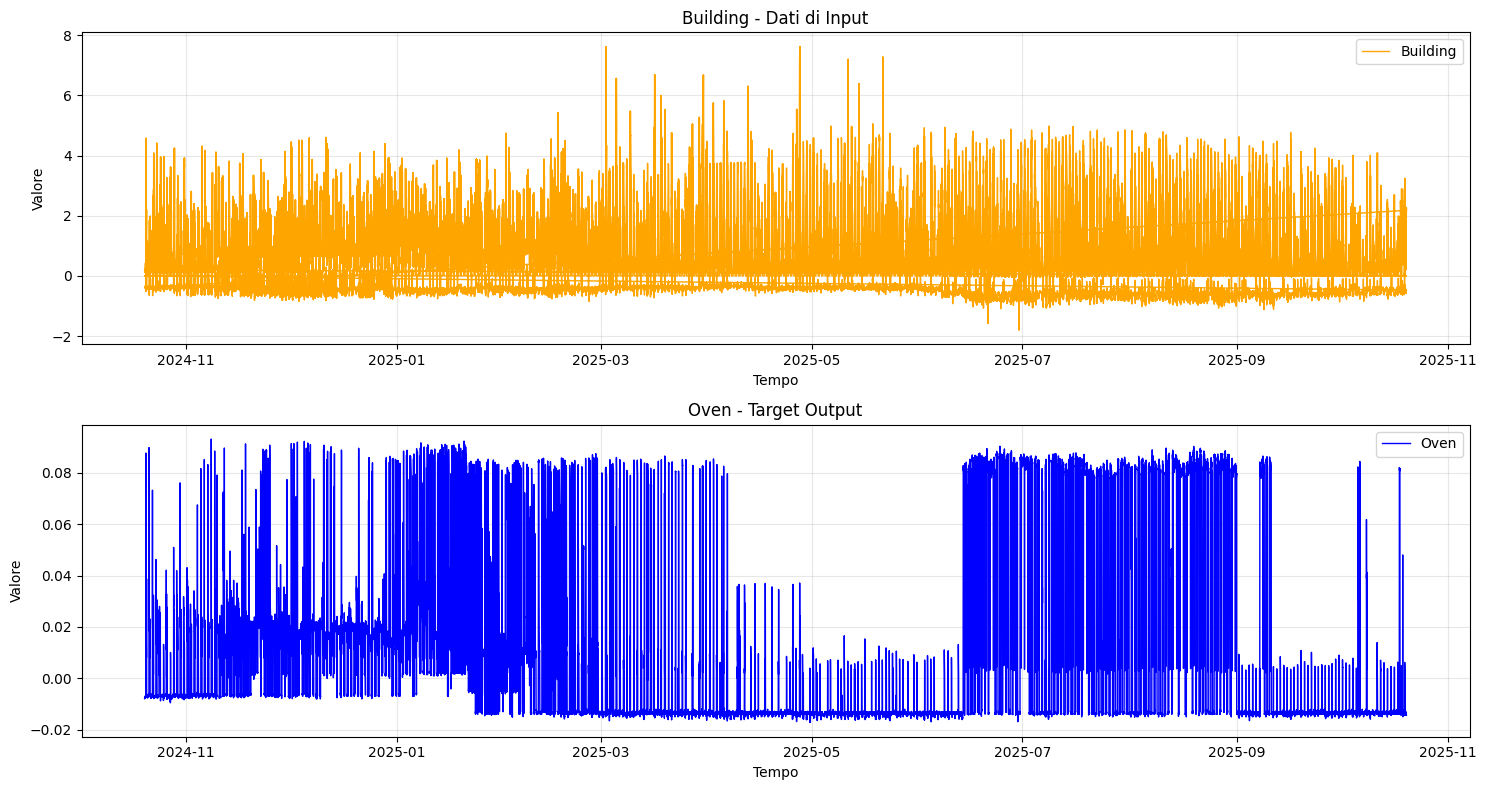

In [ ]:
# Visualize complete timelines
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

axes[0].plot(Building['_time'], Building['_value'], linewidth=1, color='orange', label='Building')
axes[0].set_title('Building - Input Data')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Value')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].plot(Oven['_time'], Oven['_value'], linewidth=1, color='blue', label='Oven')
axes[1].set_title('Oven - Target Output')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Value')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

## 4. SEQUENCE CREATION

In [ ]:
# Data normalization
from sklearn.preprocessing import MinMaxScaler

# Create scalers
input_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit scalers on complete data
Building_values = Building[['_value']].values
Oven_values = Oven[['_value']].values

input_scaler.fit(Building_values)
target_scaler.fit(Oven_values)

# Normalize the data
Building_normalized = input_scaler.transform(Building_values)
Oven_normalized = target_scaler.transform(Oven_values)

print(f"✓ Data normalized")
print(f"  Building: min={Building_normalized.min():.4f}, max={Building_normalized.max():.4f}")
print(f"  Oven: min={Oven_normalized.min():.4f}, max={Oven_normalized.max():.4f}")

def create_multi_day_sequences(input_data, target_data, input_len, output_len, step=1):
    """
    Create sequences with different input and output lengths.
    
    Args:
        input_data: normalized numpy array of input (Building)
        target_data: normalized numpy array of target (Oven)
        input_len: input sequence length
        output_len: output sequence length
        step: step between consecutive sequences
    
    Returns:
        input_sequences: list of arrays (input_len, 1)
        target_sequences: list of arrays (output_len, 1)
    """
    input_sequences = []
    target_sequences = []
    
    max_idx = min(len(input_data), len(target_data)) - input_len
    
    for i in range(0, max_idx, step):
        # Input: [i : i + input_len]
        input_seq = input_data[i:i+input_len]
        
        # Target: last output_len points of the input window
        target_start = i + input_len - output_len
        target_seq = target_data[target_start:target_start+output_len]
        
        input_sequences.append(input_seq)
        target_sequences.append(target_seq)

    return input_sequences, target_sequences

print("✓ Function create_multi_day_sequences defined")

✓ Dati normalizzati
  Building: min=0.0000, max=1.0000
  Oven: min=0.0000, max=1.0000
✓ Funzione create_multi_day_sequences definita


In [ ]:
# Create sequences with NORMALIZED data
print(f"Creating sequences: {input_days} days input → {output_days} day output...")

X_input, Y_target = create_multi_day_sequences(
    Building_normalized, Oven_normalized, 
    input_len=input_window, 
    output_len=output_window,
    step=rows_per_day  # step of 1 day
)

print(f"\n✓ Sequences created: {len(X_input)}")
print(f"✓ Input shape: {X_input[0].shape} ({input_days} days)")
print(f"✓ Target shape: {Y_target[0].shape} ({output_days} day)")
print(f"✓ Input range: [{X_input[0].min():.4f}, {X_input[0].max():.4f}]")
print(f"✓ Target range: [{Y_target[0].min():.4f}, {Y_target[0].max():.4f}]"))

Creazione sequenze: 5 giorni input → 1 giorno output...

✓ Sequenze create: 360
✓ Input shape: (480, 1) (5 giorni)
✓ Target shape: (96, 1) (1 giorno)
✓ Input range: [0.2014, 0.6767]
✓ Target range: [0.0765, 0.4095]


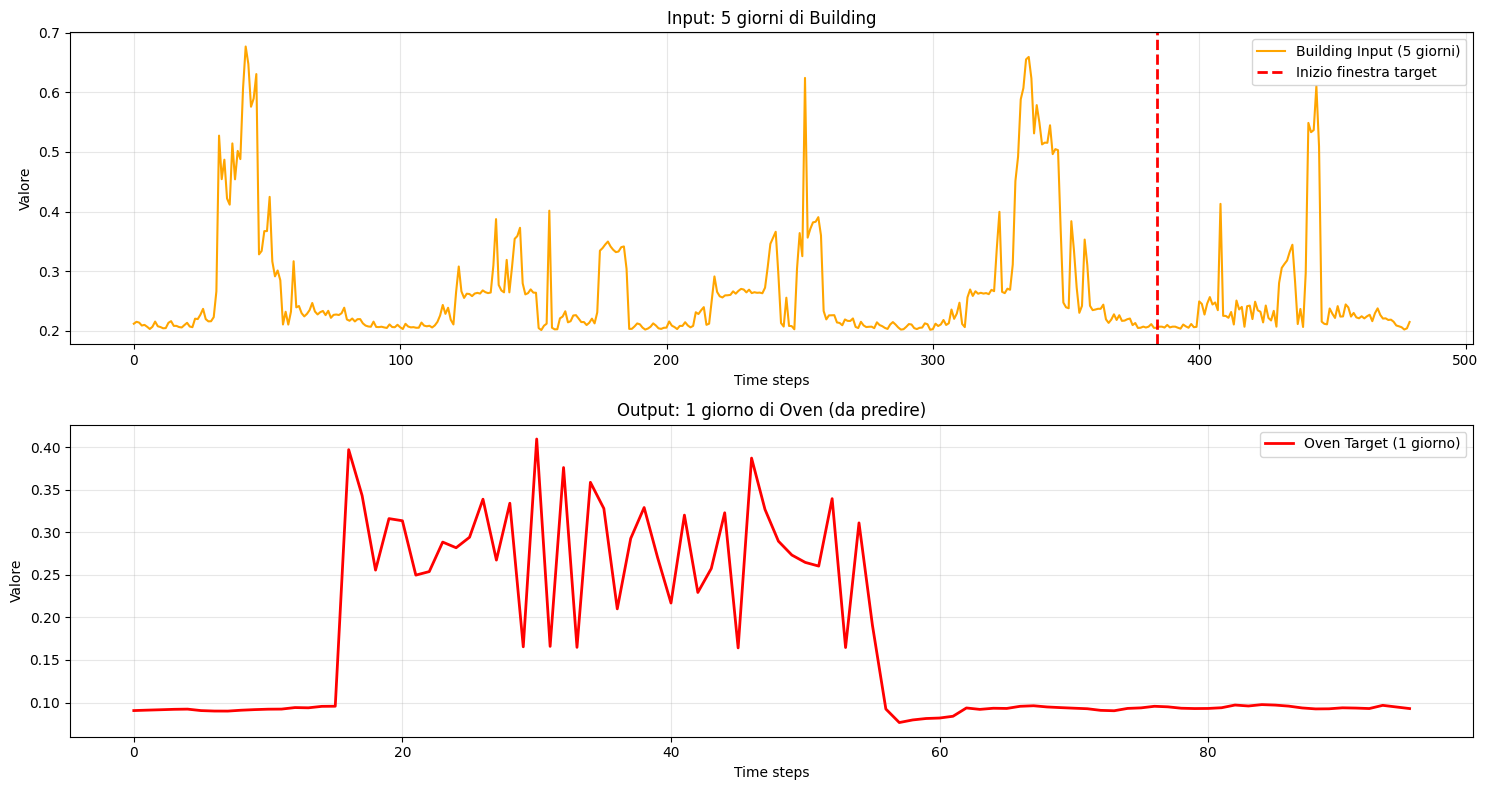


Il modello userà 5 giorni di Building per predire 1 giorno di Oven


In [ ]:
# Visualize example: 10 days input → 1 day output
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Input (10 days)
axes[0].plot(range(input_window), X_input[0].flatten(), linewidth=1.5, color='orange', label=f'Building Input ({input_days} days)')
axes[0].axvline(x=input_window - output_window, color='red', linestyle='--', linewidth=2, label='Target window start')
axes[0].set_title(f'Input: {input_days} days of Building')
axes[0].set_xlabel('Time steps')
axes[0].set_ylabel('Value')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Output (1 day)
axes[1].plot(range(output_window), Y_target[0].flatten(), linewidth=2, color='red', label=f'Oven Target ({output_days} day)')
axes[1].set_title(f'Output: {output_days} day of Oven (to predict)')
axes[1].set_xlabel('Time steps')
axes[1].set_ylabel('Value')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nThe model will use {input_days} days of Building to predict {output_days} day of Oven")

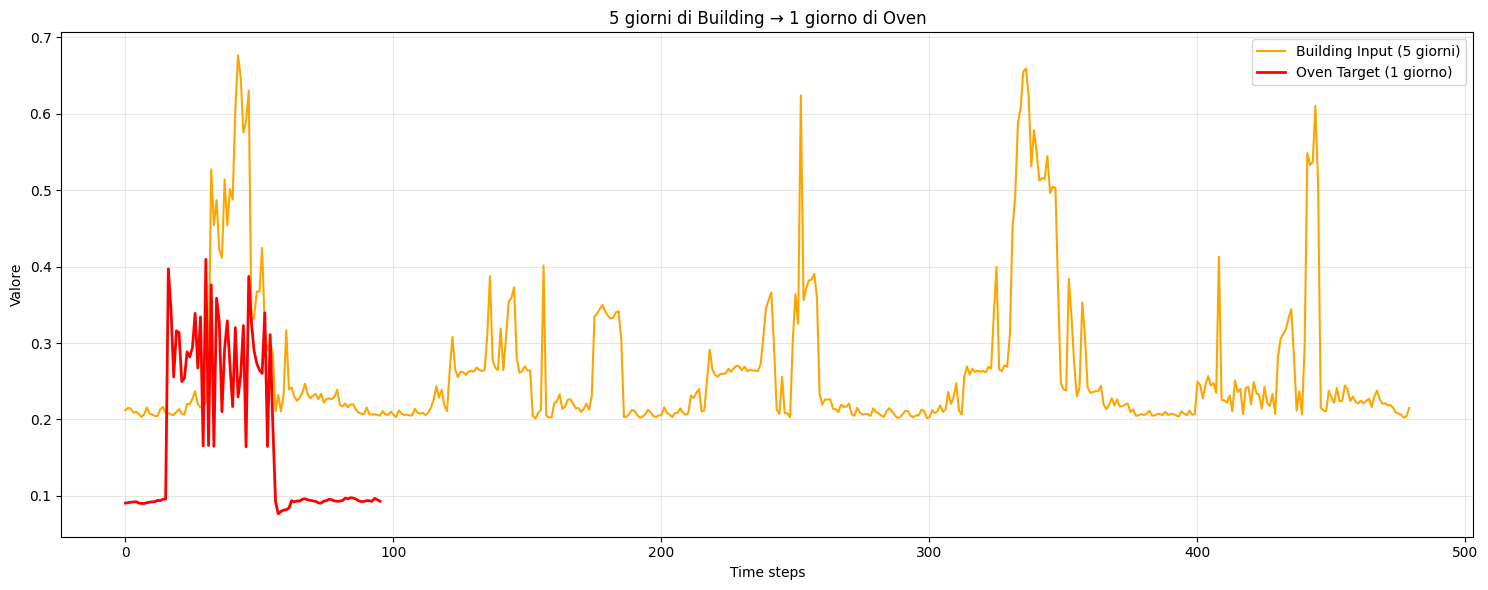


Il modello userà 5 giorni di Building per predire 1 giorno di Oven


In [ ]:
plt.figure(figsize=(15, 6))

# Input (Building)
plt.plot(
    X_input[0].flatten(),
    linewidth=1.5,
    color='orange',
    label=f'Building Input ({input_days} days)'
)

# Output (Oven) – right after the input
plt.plot(
    Y_target[0].flatten(),
    linewidth=2,
    color='red',
    label=f'Oven Target ({output_days} day)'
)

plt.title(f'{input_days} days of Building → {output_days} day of Oven')
plt.xlabel('Time steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nThe model will use {input_days} days of Building to predict {output_days} day of Oven")


## 5. MODEL DEFINITION

In [ ]:
class ResidualBlock(nn.Module):
    """Residual block for better gradient flow"""
    def __init__(self, channels, kernel_size=3, dilation=1):
        super(ResidualBlock, self).__init__()
        padding = (kernel_size - 1) * dilation // 2
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(channels)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out = out + residual  # Skip connection
        return self.relu(out)


class ChannelAttention(nn.Module):
    """Attention to weight the most important channels"""
    def __init__(self, channels, reduction=8):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)


class CNNEncoder(nn.Module):
    """Improved CNN Encoder with residual blocks and multi-scale"""
    def __init__(self, input_len, hidden_channels=64, num_layers=4):
        super(CNNEncoder, self).__init__()
        
        # Input projection
        self.input_proj = nn.Sequential(
            nn.Conv1d(1, hidden_channels, kernel_size=7, padding=3),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU()
        )
        
        # Multi-scale convolutions to capture patterns at different temporal scales
        self.multi_scale = nn.ModuleList([
            nn.Conv1d(hidden_channels, hidden_channels // 4, kernel_size=3, padding=1),
            nn.Conv1d(hidden_channels, hidden_channels // 4, kernel_size=7, padding=3),
            nn.Conv1d(hidden_channels, hidden_channels // 4, kernel_size=15, padding=7),
            nn.Conv1d(hidden_channels, hidden_channels // 4, kernel_size=31, padding=15),
        ])
        
        # Residual blocks with increasing dilation
        self.residual_blocks = nn.ModuleList([
            ResidualBlock(hidden_channels, kernel_size=3, dilation=2**i)
            for i in range(num_layers)
        ])
        
        # Channel attention
        self.attention = ChannelAttention(hidden_channels)
        
        self.input_len = input_len
        
    def forward(self, x):
        # x: (batch, input_len, 1) -> (batch, 1, input_len)
        x = x.transpose(1, 2)
        
        # Input projection
        x = self.input_proj(x)
        
        # Multi-scale features
        multi_scale_out = [conv(x) for conv in self.multi_scale]
        x = torch.cat(multi_scale_out, dim=1)
        
        # Residual blocks
        for block in self.residual_blocks:
            x = block(x)
        
        # Attention
        x = self.attention(x)
        
        return x


class CNNDecoder(nn.Module):
    """Improved CNN Decoder"""
    def __init__(self, input_len, output_len, hidden_channels=64, num_layers=4):
        super(CNNDecoder, self).__init__()
        
        self.input_len = input_len
        self.output_len = output_len
        
        # Adaptive pooling to reduce dimension
        self.adaptive_pool = nn.AdaptiveAvgPool1d(output_len)
        
        # Residual blocks
        self.residual_blocks = nn.ModuleList([
            ResidualBlock(hidden_channels, kernel_size=3)
            for _ in range(num_layers)
        ])
        
        # Attention
        self.attention = ChannelAttention(hidden_channels)
        
        # Output projection with multiple layers
        self.output_proj = nn.Sequential(
            nn.Conv1d(hidden_channels, hidden_channels // 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels // 2),
            nn.ReLU(),
            nn.Conv1d(hidden_channels // 2, 1, kernel_size=1)
        )
        
    def forward(self, encoder_features):
        # Reduce from input_len to output_len
        x = self.adaptive_pool(encoder_features)
        
        # Residual blocks
        for block in self.residual_blocks:
            x = block(x)
        
        # Attention
        x = self.attention(x)
        
        # Output
        output = self.output_proj(x)
        return output.transpose(1, 2)


class CNNSeq2Day(nn.Module):
    """
    Improved CNN model: Long Input (N days) → Short Output (1 day)
    With residual connections, multi-scale convolutions and attention
    """
    def __init__(self, input_len, output_len, hidden_channels=64, num_layers=4):
        super(CNNSeq2Day, self).__init__()
        self.encoder = CNNEncoder(input_len, hidden_channels, num_layers)
        self.decoder = CNNDecoder(input_len, output_len, hidden_channels, num_layers)
        self.input_len = input_len
        self.output_len = output_len
        
    def forward(self, source):
        encoder_features = self.encoder(source)
        output = self.decoder(encoder_features)
        return output

print("✓ IMPROVED CNN Seq2Day Model defined")
print(f"  - Input: {input_days} days ({input_window} steps)")
print(f"  - Output: {output_days} day ({output_window} steps)")
print("  - Features: Residual blocks, Multi-scale conv, Channel attention")

✓ Modello CNN Seq2Day MIGLIORATO definito
  - Input: 5 giorni (480 steps)
  - Output: 1 giorno (96 steps)
  - Features: Residual blocks, Multi-scale conv, Channel attention


## 6. DATA PREPARATION FOR TRAINING

In [ ]:
class EnergyDataset(Dataset):
    def __init__(self, input_sequences, target_sequences):
        # Convert lists of numpy arrays to tensors
        self.input_sequences = [torch.FloatTensor(seq) for seq in input_sequences]
        self.target_sequences = [torch.FloatTensor(seq) for seq in target_sequences]
    
    def __len__(self):
        return len(self.input_sequences)
    
    def __getitem__(self, idx):
        return self.input_sequences[idx], self.target_sequences[idx]

print("✓ EnergyDataset defined")

✓ EnergyDataset definito


## 7. TRAINING

In [ ]:
# ===== IMPROVED CNN Seq2Day CONFIGURATION =====

batch_size = 64           # Smaller batch size for better generalization
hidden_channels = 128     # CNN channels
num_layers = 4            # CNN layers
num_epochs = 150          # More epochs
learning_rate = 0.0005    # Lower learning rate

# Create dataset and dataloader
train_dataset = EnergyDataset(X_input, Y_target)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

num_sequences = len(X_input)
num_batches = len(train_loader)

print("=" * 60)
print("IMPROVED CNN Seq2Day CONFIGURATION")
print("=" * 60)
print(f"Input: {input_days} days ({input_window} steps)")
print(f"Output: {output_days} day ({output_window} steps)")
print(f"Sequences: {num_sequences:,}")
print(f"Batch size: {batch_size} | Batches/epoch: {num_batches}")
print(f"Model: CNN with {num_layers} layers, {hidden_channels} channels")
print(f"Learning rate: {learning_rate}")
print(f"Device: {'GPU 🚀' if torch.cuda.is_available() else 'CPU'}")
print("=" * 60)

# Setup device and model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNSeq2Day(input_window, output_window, hidden_channels, num_layers).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"\n✓ Improved CNN model: {total_params:,} parameters")

# Loss function - Huber Loss (more robust to outliers)
class CombinedLoss(nn.Module):
    """Combination of MSE and MAE to balance accuracy and robustness"""
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.mse = nn.MSELoss()
        self.mae = nn.L1Loss()
    
    def forward(self, predictions, targets):
        mse_loss = self.mse(predictions, targets)
        mae_loss = self.mae(predictions, targets)
        return self.alpha * mse_loss + (1 - self.alpha) * mae_loss

criterion = CombinedLoss(alpha=0.6)  # 60% MSE, 40% MAE
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=2)

print("✓ Combined loss (MSE + MAE) and AdamW optimizer configured")
print("✓ Cosine annealing scheduler active")

CONFIGURAZIONE CNN Seq2Day MIGLIORATA
Input: 5 giorni (480 steps)
Output: 1 giorno (96 steps)
Sequenze: 360
Batch size: 64 | Batches/epoca: 6
Modello: CNN con 4 layer, 128 canali
Learning rate: 0.0005
Device: GPU 🚀

✓ Modello CNN migliorato: 1,056,385 parametri
✓ Loss combinata (MSE + MAE) e AdamW optimizer configurati
✓ Cosine annealing scheduler attivo


In [ ]:
import time

def train_epoch(model, iterator, optimizer, criterion, device, scheduler=None):
    model.train()
    epoch_loss = 0
    start_time = time.time()
    
    for input_seq, target_seq in iterator:
        input_seq = input_seq.to(device)
        target_seq = target_seq.to(device)
        
        output = model(input_seq)
        loss = criterion(output, target_seq)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    if scheduler is not None:
        scheduler.step()
    
    elapsed = time.time() - start_time
    return epoch_loss / len(iterator), elapsed

# Training con early stopping
train_losses = []
best_loss = float('inf')
patience = 20
patience_counter = 0

print(f"\n🚀 Starting IMPROVED CNN Seq2Day training ({num_epochs} epochs)...")
print(f"   Input: {input_days} days → Output: {output_days} day")
print(f"   Early stopping: patience={patience}\n")

for epoch in range(num_epochs):
    train_loss, elapsed = train_epoch(model, train_loader, optimizer, criterion, device, scheduler)
    train_losses.append(train_loss)
    
    # Early stopping
    if train_loss < best_loss:
        best_loss = train_loss
        patience_counter = 0
        # Save the best model
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1:3d}/{num_epochs} | Loss: {train_loss:.6f} | LR: {lr:.6f} | Time: {elapsed:.1f}s")
    
    if patience_counter >= patience:
        print(f"\n⚠️ Early stopping at epoch {epoch+1}")
        break

# Load the best model
model.load_state_dict(best_model_state)
print(f"\n✓ Training completed! Best loss: {best_loss:.6f}")


🚀 Inizio training CNN Seq2Day MIGLIORATO (150 epoche)...
   Input: 5 giorni → Output: 1 giorno
   Early stopping: patience=20

Epoch   1/150 | Loss: 0.202160 | LR: 0.000499 | Time: 0.5s
Epoch  10/150 | Loss: 0.110772 | LR: 0.000375 | Time: 0.2s
Epoch  20/150 | Loss: 0.092611 | LR: 0.000125 | Time: 0.2s
Epoch  30/150 | Loss: 0.088819 | LR: 0.000500 | Time: 0.2s
Epoch  40/150 | Loss: 0.086854 | LR: 0.000467 | Time: 0.2s
Epoch  50/150 | Loss: 0.079620 | LR: 0.000375 | Time: 0.2s
Epoch  60/150 | Loss: 0.072202 | LR: 0.000250 | Time: 0.2s
Epoch  70/150 | Loss: 0.068540 | LR: 0.000125 | Time: 0.2s
Epoch  80/150 | Loss: 0.062918 | LR: 0.000033 | Time: 0.2s
Epoch  90/150 | Loss: 0.061127 | LR: 0.000500 | Time: 0.2s
Epoch 100/150 | Loss: 0.068315 | LR: 0.000491 | Time: 0.2s

⚠️ Early stopping at epoch 109

✓ Training completato! Best loss: 0.060065


## 8. RESULTS & VISUALIZATION

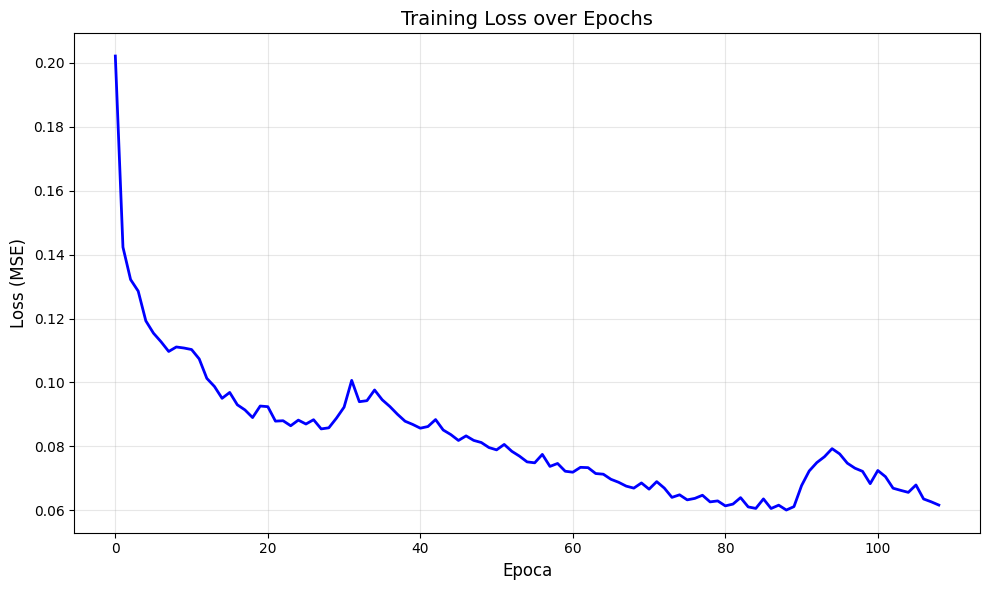

Loss iniziale: 0.202160
Loss finale: 0.061615


In [ ]:
# Plot loss during training
plt.figure(figsize=(10, 6))
plt.plot(train_losses, linewidth=2, color='blue')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training Loss over Epochs', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Initial loss: {train_losses[0]:.6f}")
print(f"Final loss: {train_losses[-1]:.6f}")

# Salva il modello
model_path = "seq2day_cnn_energy_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'hyperparameters': {
        'hidden_channels': hidden_channels,
        'num_layers': num_layers,
        'input_window': input_window,
        'output_window': output_window,
        'input_days': input_days,
        'output_days': output_days
    },

    'train_losses': train_lossesprint(f"✓ Modello CNN Seq2Day salvato: {model_path}")
}, model_path)

## 9. INFERENCE & EVALUATION

In [ ]:
# Test on a sequence
test_idx = 5  # Choose an index for testing

model.eval()
with torch.no_grad():
    test_input = torch.FloatTensor(X_input[test_idx]).unsqueeze(0).to(device)
    test_target = torch.FloatTensor(Y_target[test_idx]).unsqueeze(0).to(device)
    
    predictions_norm = model(test_input)
    predictions_norm = predictions_norm.cpu().numpy().squeeze()
    actual_norm = test_target.cpu().numpy().squeeze()

# Denormalize to see the real values
predictions = target_scaler.inverse_transform(predictions_norm.reshape(-1, 1)).flatten()
actual = target_scaler.inverse_transform(actual_norm.reshape(-1, 1)).flatten()

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actual, predictions)
mae = mean_absolute_error(actual, predictions)

# Also calculate R² score
from sklearn.metrics import r2_score
r2 = r2_score(actual, predictions)

print(f"Test on sequence {test_idx}:")
print(f"  Input: {input_days} days of Building")
print(f"  Output: {output_days} day of Oven predicted")
print(f"\n📊 Metrics (denormalized values):")
print(f"  MSE: {mse:.6f}")
print(f"  MAE: {mae:.6f}")
print(f"  R²:  {r2:.4f}")

Test su sequenza 5:
  Input: 5 giorni di Building
  Output: 1 giorno di Oven predetto

📊 Metriche (valori denormalizzati):
  MSE: 0.000198
  MAE: 0.009779
  R²:  0.2091


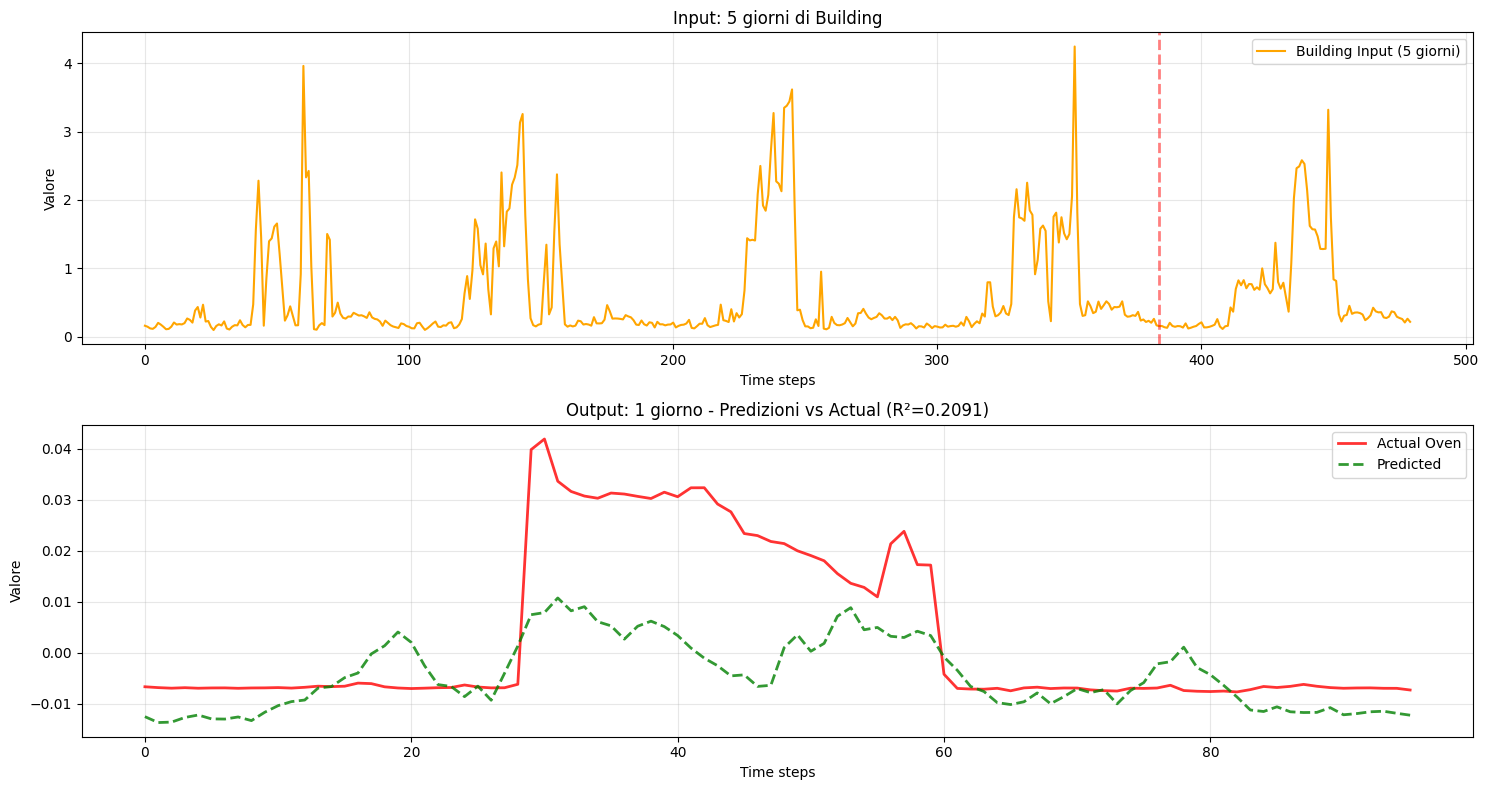


📊 Test su sequenze multiple:
  Media MSE: 0.000152
  Media MAE: 0.008958
  Media R²:  0.2487


In [ ]:
# Visualize predictions vs actual (denormalized)
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Input used (denormalized)
input_denorm = input_scaler.inverse_transform(X_input[test_idx]).flatten()
axes[0].plot(range(input_window), input_denorm, linewidth=1.5, color='orange', label=f'Building Input ({input_days} days)')
axes[0].axvline(x=input_window - output_window, color='red', linestyle='--', linewidth=2, alpha=0.5)
axes[0].set_title(f'Input: {input_days} days of Building')
axes[0].set_xlabel('Time steps')
axes[0].set_ylabel('Value')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Predicted output vs actual
axes[1].plot(range(output_window), actual, linewidth=2, label='Actual Oven', color='red', alpha=0.8)
axes[1].plot(range(output_window), predictions, linewidth=2, label='Predicted', color='green', linestyle='--', alpha=0.8)
axes[1].set_title(f'Output: {output_days} day - Predictions vs Actual (R²={r2:.4f})')
axes[1].set_xlabel('Time steps')
axes[1].set_ylabel('Value')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test on multiple sequences for a more complete view
print("\n📊 Test on multiple sequences:")
test_indices = [0, 5, 10, 15, 20]
all_mse, all_mae, all_r2 = [], [], []

model.eval()
with torch.no_grad():
    for idx in test_indices:
        if idx < len(X_input):
            inp = torch.FloatTensor(X_input[idx]).unsqueeze(0).to(device)
            tgt = torch.FloatTensor(Y_target[idx]).unsqueeze(0).to(device)
            
            pred = model(inp).cpu().numpy().squeeze()
            act = tgt.cpu().numpy().squeeze()
            
            # Denormalize
            pred_denorm = target_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
            act_denorm = target_scaler.inverse_transform(act.reshape(-1, 1)).flatten()
            
            all_mse.append(mean_squared_error(act_denorm, pred_denorm))
            all_mae.append(mean_absolute_error(act_denorm, pred_denorm))
            all_r2.append(r2_score(act_denorm, pred_denorm))

print(f"  Average MSE: {np.mean(all_mse):.6f}")
print(f"  Average MAE: {np.mean(all_mae):.6f}")
print(f"  Average R²:  {np.mean(all_r2):.4f}")